# Predicting the Type of Angina/Chest Pain based on Age and Blood Pressure

## Introduction:
Heart disease is an extremely prevalent health issue around the world. Angina is chest pain which is experienced by individuals who fail to get enough oxygen rich blood into parts of their heart muscle. Anginas can be a sign of coronary artery disease and a warning symptom of a heart attack. Angiography is an X-ray taken of the coronary arteries which is often used to diagnose heart disease. 
 
How do age and resting blood pressure influence the type of chest pain seen in patients admitted to the university hospitals in Zurich and Basel?
 
We will be using the heart Disease dataset from the Switzerland database. This dataset contains a set of 14 variables; the data was collected from 143 patients undergoing angiography in university hospitals in Zurich and Basel. Chest pain type (cp) is described by 4 values:  1 is a typical angina, 2 is an atypical angina, 3 is non-anginal pain, and 4 is asymptomatic. Trestbps represents resting blood pressure and age represents the age of the patient.






In [36]:
#import packages
library(readr)
library(tidyverse)
library(dplyr)
library(tidymodels)

In [37]:
heart_data <- read_csv('data/processed.switzerland.data', col_names=FALSE)
heart_data |> sample_n(6)
heart_data <- heart_data |> select(X1, X3, X4)
heart_data <- heart_data |> rename(age=X1, chest_pain_ctg=X3, blood_pressure_mm_Hg=X4) |> 
                                        filter(blood_pressure_mm_Hg != "?")

heart_data |> sample_n(6)

Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X6, X7, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X5, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
50,1,4,120,0,0,1,156,1,0,1,?,6,3
56,1,4,125,0,1,0,103,1,1,2,?,7,3
58,1,4,170,0,?,1,105,1,0,?,?,3,1
36,1,4,110,0,?,0,125,1,1,2,?,6,1
63,1,4,140,0,?,2,149,0,2,1,?,?,2
53,1,2,130,0,?,1,120,0,.7,3,?,?,0


age,chest_pain_ctg,blood_pressure_mm_Hg
<dbl>,<dbl>,<chr>
50,4,160
61,4,130
58,4,130
60,4,160
61,4,150
57,4,140


In this project, we want to predict the 'diagnosis' label with three predictors -  age, chest pain type, and rest blood pressure. The diagnosis label represents . 

We can see that the data is pretty tidy, so we can proceed to wrangle the data to a form that is appropriate for classification training.

In [38]:
set.seed(686)

#Get column 1, 3, 4, plot age vs blood pressure, colour seperated by type of chest pain

# transform and rename the 'Class' factor values to be more readable
heart_data <- heart_data |>
    mutate(blood_pressure_mm_Hg = as.numeric(blood_pressure_mm_Hg)) |>
    mutate(chest_pain_ctg = as_factor(chest_pain_ctg)) |> 
    mutate(chest_pain_ctg = fct_recode(chest_pain_ctg, "typical" = "1", "atypical" = "2", "non-anginal" = "3", "asymptomatic" = "4"))
heart_data |> sample_n(6)

age,chest_pain_ctg,blood_pressure_mm_Hg
<dbl>,<fct>,<dbl>
50,asymptomatic,120
63,asymptomatic,150
54,asymptomatic,180
53,asymptomatic,130
55,asymptomatic,120
51,asymptomatic,130


Let's create a visualization of our data with Blood Pressure on the x axis, Age on the y axis, shape-coded by chest pain type and colour-coded by whether if the subject has a heart disease.

Looks great! Our data is now ready to be split into training and testing sets!

In [41]:
# split our dataset into training and testing sets.
heart_split <- initial_split(heart_data, prop = 0.75, strata = chest_pain_ctg)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

glimpse(heart_train)
glimpse(heart_test)

heart_proportions <- heart_train |>
                      group_by(chest_pain_ctg) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(heart_train))
heart_proportions

Rows: 90
Columns: 3
$ age                  <dbl> 34, 36, 38, 38, 38, 40, 41, 43, 43, 46, 48, 50, 5…
$ chest_pain_ctg       <fct> asymptomatic, asymptomatic, asymptomatic, asympto…
$ blood_pressure_mm_Hg <dbl> 115, 110, 105, 110, 150, 95, 125, 100, 140, 100, …
Rows: 31
Columns: 3
$ age                  <dbl> 38, 38, 42, 42, 43, 46, 47, 47, 50, 51, 51, 52, 5…
$ chest_pain_ctg       <fct> non-anginal, asymptomatic, asymptomatic, asymptom…
$ blood_pressure_mm_Hg <dbl> 100, 135, 105, 145, 115, 115, 110, 160, 160, 110,…


chest_pain_ctg,n,percent
<fct>,<int>,<dbl>
typical,4,4.444444
atypical,4,4.444444
non-anginal,12,13.333333
asymptomatic,70,77.777778


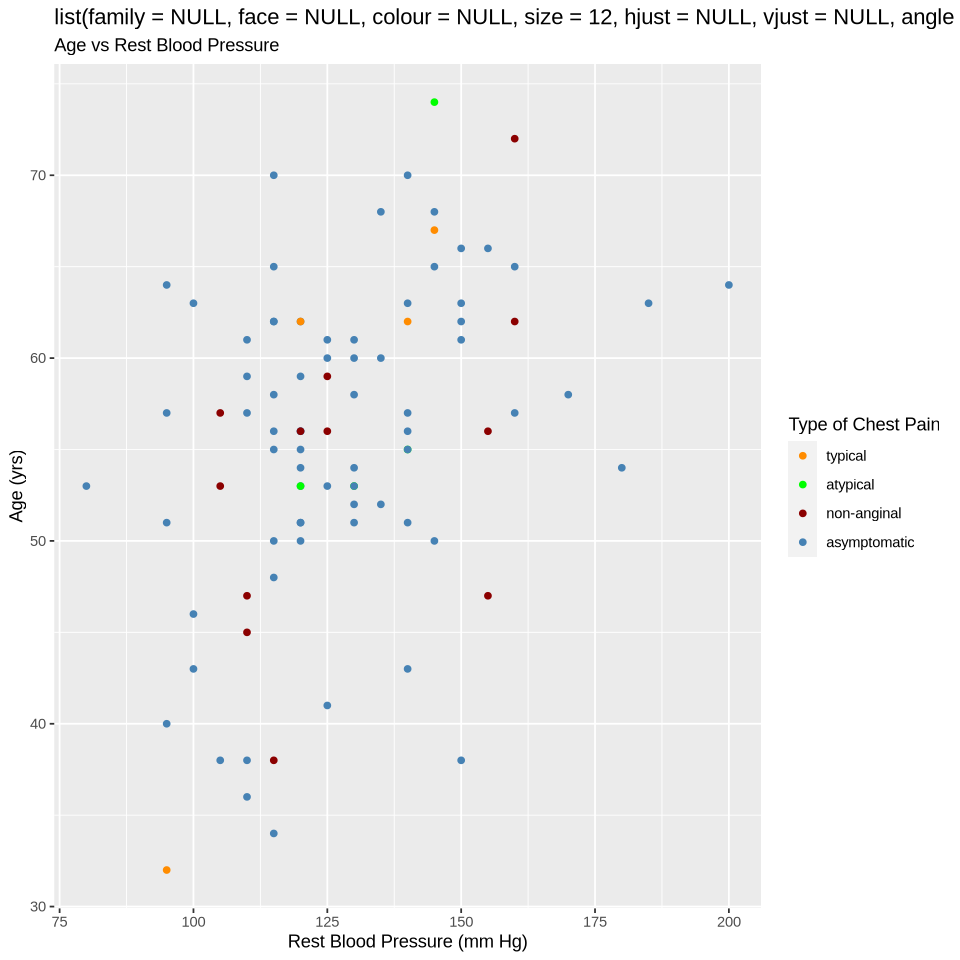

In [42]:
options(repr.plot.height = 8, repr.plot.width = 8)

# create scatter plot of heart disease training set.

heart_disease_plot <- heart_train |>
  ggplot(aes(x = blood_pressure_mm_Hg, y = age, color=chest_pain_ctg)) +
  geom_point() +
  labs(color = "Type of Chest Pain",  x="Rest Blood Pressure (mm Hg)", y="Age (yrs)") +
  scale_color_manual(values = c("darkorange", "green", "darkred", "steelblue")) +
  theme(text = element_text(size = 12)) |>
  ggtitle("Age vs Rest Blood Pressure")

heart_disease_plot

## Methods:
For this classification, we will use the predictive variables age and resting blood pressure to predict the type of chest pain seen in patients.

First we will load in the dataset, tidy it, mutate ‘cp’ to an ‘as_factor’ variable, and select for age, cp, and trestbps columns. Next we will split our data into training and testing sets, create a recipe (center and scale), perform a cross-validation, create a K-nearest neighbors classifier and tune the model, and train the classifier with the training set using a workflow. From the workflow we will filter .metric for accuracy,  plot a neighbors vs. accuracy plot to visualize the best number of neighbors to set our final model. We will build a new K-nearest neighbors model with the ideal K value and run that through a workflow; this model will be used to predict the class for the test set (predict type of chest pain). 

One way we plan to visualize is to create a plot with the predictors on each axis and a different colour for each value of chest pain to visualize how the predictors can be used to predict the type of chest pain.



## Expected Outcomes and Significance:

We expect to find the following information:
-	Most of the cases being asymptomatic.
-	Have non-anginal cases having a blood pressure near either 110 or 155.
-	Have typical cases mostly beyond the age of 60.
-	Have very rare, atypical cases, but when there is on, have them with a blood pressure around 145 and an age higher than 70.

Such findings can lead to a better categorization of the chest pain to help doctors to correctly medicate a patience even if they wrongly describe the pain. As an example, the patience could think he felt a typical chest pain, but he is 50 and has a blood pressure of 160 meaning that he is more probable to a non-anginal type than a typical type. In this case, the medic could try to make countermeasures by re-examining the patience to make sure that he is given the correct medication.

This could lead to studies about the correlation between the pain and the treatment and studies on how to better examine the patient. Not only that, but questions about the blood pressure correlation to the pain can also appear, having studies about how medication can change the blood pressure to help alleviate the pain of the patients.



We expect to find that as age and resting blood pressure increases, the amount of typical angina will increase. An increase in age and resting blood pressure seems to be prime conditions for the appearance of typical angina compared to other types of chest pain because arteries seem to weaken with age and high blood pressure is linked to symptoms like typical angina. 
 
These findings could be impactful because it is possible that individuals with higher blood pressure may take steps to decrease their resting blood pressure levels if higher blood pressure does have an impact on the amount and type of chest pain.
#### Future question: Is one type of chest pain more likely to be linked to diagnosed heart disease? 

In [46]:
# Create recipe
heart_recipe <- recipe(chest_pain_ctg ~ ., data = heart_train) |>
  step_scale(all_numeric_predictors()) |>
  step_center(all_numeric_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# cross-validation for best number of neighbours
heart_vfold <- vfold_cv(heart_train, v = 5, strata = chest_pain_ctg)
k_vals <- tibble(neighbors = seq(from = 2, to = 6, by = 1))

# collect metrics for each number of neighbours
knn_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heart_vfold, grid = k_vals) |>
  collect_metrics()

# get their accuracies
accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies


→ A | warning: No observations were detected in `truth` for level(s): 'typical'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

→ B | warning: No observations were detected in `truth` for level(s): 'atypical'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x1

→ C | warning: No observations were detected in `truth` for level(s): 'typical', 'atypical'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1   B: x1
There were issues with some computations   A: x1   B: x1   C: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.6336773,5,0.01974409,Preprocessor1_Model1
3,accuracy,multiclass,0.7011352,5,0.02383789,Preprocessor1_Model2
4,accuracy,multiclass,0.7011352,5,0.02383789,Preprocessor1_Model3
5,accuracy,multiclass,0.7679395,5,0.01601809,Preprocessor1_Model4
6,accuracy,multiclass,0.7679395,5,0.01601809,Preprocessor1_Model5
